Predictive Threat Intelligence Using Machine Learning for CVE Analysis

Name: Karan, Jithu, Enriketa, Chinmay 
Department: M.S. in Cybersecurity
College: Pace University, New York
2024–2025

In [285]:
import requests
import re
import os
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import unicodedata
import itertools
import logging
from os import listdir
from os.path import isfile, join
from typing import KeysView
from pandas.core.frame import DataFrame
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import balanced_accuracy_score

In [287]:
import os
from os import makedirs
from os.path import isfile, join

def get_nvd_data():
    r = requests.get('https://nvd.nist.gov/vuln/data-feeds#JSON_FEED')
    for filename in re.findall("nvdcve-1.1-[0-9]*\.json\.zip",r.text):
        print(filename)
        r_file = requests.get("https://nvd.nist.gov/feeds/json/cve/1.1/" + filename, stream=True)
        filePath = "zipFile"
        if not os.path.exists(filePath):
            os.makedirs(filePath)
        with open("zipFile/" + filename, 'wb') as f:
            for chunk in r_file:
                f.write(chunk)
get_nvd_data()

nvdcve-1.1-2025.json.zip
nvdcve-1.1-2024.json.zip
nvdcve-1.1-2023.json.zip
nvdcve-1.1-2022.json.zip
nvdcve-1.1-2021.json.zip
nvdcve-1.1-2020.json.zip
nvdcve-1.1-2019.json.zip
nvdcve-1.1-2018.json.zip
nvdcve-1.1-2017.json.zip
nvdcve-1.1-2016.json.zip
nvdcve-1.1-2015.json.zip
nvdcve-1.1-2014.json.zip
nvdcve-1.1-2013.json.zip
nvdcve-1.1-2012.json.zip
nvdcve-1.1-2011.json.zip
nvdcve-1.1-2010.json.zip
nvdcve-1.1-2009.json.zip
nvdcve-1.1-2008.json.zip
nvdcve-1.1-2007.json.zip
nvdcve-1.1-2006.json.zip
nvdcve-1.1-2005.json.zip
nvdcve-1.1-2004.json.zip
nvdcve-1.1-2003.json.zip
nvdcve-1.1-2002.json.zip


In [289]:
import os
def unzip_data():
    files = [f for f in listdir("zipFile/") if isfile(join("zipFile/", f))]
    files.sort()
    for file in files:
        print("Opening: " + file)
        archive = zipfile.ZipFile(join("zipFile/", file), 'r')
        filePath = "jsonFile"
        if not os.path.exists(filePath):
            os.makedirs(filePath)
        with archive as f:
            f.extractall('jsonFile')
unzip_data()

Opening: nvdcve-1.1-2002.json.zip
Opening: nvdcve-1.1-2003.json.zip
Opening: nvdcve-1.1-2004.json.zip
Opening: nvdcve-1.1-2005.json.zip
Opening: nvdcve-1.1-2006.json.zip
Opening: nvdcve-1.1-2007.json.zip
Opening: nvdcve-1.1-2008.json.zip
Opening: nvdcve-1.1-2009.json.zip
Opening: nvdcve-1.1-2010.json.zip
Opening: nvdcve-1.1-2011.json.zip
Opening: nvdcve-1.1-2012.json.zip
Opening: nvdcve-1.1-2013.json.zip
Opening: nvdcve-1.1-2014.json.zip
Opening: nvdcve-1.1-2015.json.zip
Opening: nvdcve-1.1-2016.json.zip
Opening: nvdcve-1.1-2017.json.zip
Opening: nvdcve-1.1-2018.json.zip
Opening: nvdcve-1.1-2019.json.zip
Opening: nvdcve-1.1-2020.json.zip
Opening: nvdcve-1.1-2021.json.zip
Opening: nvdcve-1.1-2022.json.zip
Opening: nvdcve-1.1-2023.json.zip
Opening: nvdcve-1.1-2024.json.zip
Opening: nvdcve-1.1-2025.json.zip


In [291]:
import os
import json
import csv
from os.path import join, isfile
from typing import Dict

def create_nvd_dict(year: int) -> Dict:
    """
    Loads a JSON CVE file for a specific year and returns it as a dictionary.
    """
    file_path = join("jsonFile", f"nvdcve-1.1-{year}.json")
    with open(file_path, encoding="utf-8") as json_file:
        return json.load(json_file)


def generate_cvssv3_csv_for_training():
    """
    Parses all CVE JSON files in 'jsonFile/', extracts CVSS v3 metrics,
    and writes them into separate yearly CSV files under 'trainCVSSV3/'.
    """
    json_files = sorted([f for f in os.listdir("jsonFile") if isfile(join("jsonFile", f))])
    start_year = 2002
    os.makedirs("trainCVSSV3", exist_ok=True)

    for idx, _ in enumerate(json_files):
        year = start_year + idx
        cve_data = create_nvd_dict(year)
        output_filename = f"trainCVSSV3/NVD_{year}_CVSSV3_train.csv"

        with open(output_filename, 'w', newline='', encoding='utf-8') as f_out:
            writer = csv.writer(f_out)
            writer.writerow([
                'CVE_ID', 'PublishTime', 'ModifyTime', 'Report', 'CVSSV3',
                'AttackVector', 'AttackComplexity', 'PrivilegesRequired',
                'UserInteraction', 'Scope', 'ConfidentialityImpact',
                'IntegrityImpact', 'AvailabilityImpact'
            ])

            for item in cve_data.get('CVE_Items', []):
                cve_id = item['cve']['CVE_data_meta']['ID']
                report = item['cve']['description']['description_data'][0]['value']
                publish = item.get('publishedDate', '')
                modify = item.get('lastModifiedDate', '')

                if "**REJECT**" in report:
                    continue

                impact_data = item.get('impact', {})
                base_metric = impact_data.get('baseMetricV3', {}).get('cvssV3', None)

                if base_metric:
                    writer.writerow([
                        cve_id, publish, modify, report, base_metric.get('baseScore', ''),
                        base_metric.get('attackVector', ''),
                        base_metric.get('attackComplexity', ''),
                        base_metric.get('privilegesRequired', ''),
                        base_metric.get('userInteraction', ''),
                        base_metric.get('scope', ''),
                        base_metric.get('confidentialityImpact', ''),
                        base_metric.get('integrityImpact', ''),
                        base_metric.get('availabilityImpact', '')
                    ])


In [293]:
generate_cvssv3_csv_for_training()

In [295]:
import pandas as pd
import os

def generate_CombinedFile():
    list_of_files = os.listdir("trainCVSSV3/")
    number_files = len(list_of_files) - 1  # Assuming -1 is necessary
    dataframes = []

    for year in range(2002, 2002 + number_files):
        file_name = f"NVD_{year}_CVSSV3_train.csv"
        file_path = os.path.join("trainCVSSV3", file_name)

        try:
            df = pd.read_csv(file_path, encoding="ISO-8859-1")  
            dataframes.append(df)
        except UnicodeDecodeError:
            print(f"Encoding issue with {file_name}. Trying a different encoding...")
            df = pd.read_csv(file_path, encoding="latin-1")  # We can use this as Alternative encoding
            dataframes.append(df)

    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df



In [297]:
df = generate_CombinedFile()

In [299]:
print("Schema:\n\n",df.dtypes)
print("Number of vulnerability reports,columns=",df.shape)

Schema:

 CVE_ID                    object
PublishTime               object
ModifyTime                object
Report                    object
CVSSV3                   float64
AttackVector              object
AttackComplexity          object
PrivilegesRequired        object
UserInteraction           object
Scope                     object
ConfidentialityImpact     object
IntegrityImpact           object
AvailabilityImpact        object
dtype: object
Number of vulnerability reports,columns= (145515, 13)


In [301]:
df = df[~df['Report'].str.contains('REJECT')]
# Print schema
print("Schema:\n\n",df.dtypes)
print("Number of vulnerability reports,columns=",df.shape)

Schema:

 CVE_ID                    object
PublishTime               object
ModifyTime                object
Report                    object
CVSSV3                   float64
AttackVector              object
AttackComplexity          object
PrivilegesRequired        object
UserInteraction           object
Scope                     object
ConfidentialityImpact     object
IntegrityImpact           object
AvailabilityImpact        object
dtype: object
Number of vulnerability reports,columns= (145508, 13)


In [303]:
df.sample(2)

,CVE_ID,PublishTime,ModifyTime,Report,CVSSV3,AttackVector,AttackComplexity,PrivilegesRequired,UserInteraction,Scope,ConfidentialityImpact,IntegrityImpact,AvailabilityImpact
66644,CVE-2021-31511,2021-06-29T15:15Z,2024-11-21T06:05Z,This vulnerability allows remote attackers to ...,7.8,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,HIGH,HIGH
103860,CVE-2023-2291,2023-04-26T21:15Z,2025-02-03T18:15Z,Static credentials exist in the PostgreSQL dat...,7.8,LOCAL,LOW,LOW,NONE,UNCHANGED,HIGH,HIGH,HIGH


In [305]:
import plotly.express as px

px.data_frame = df[['CVE_ID', 'Report', 'AttackVector', 'AvailabilityImpact']].sample(10)
px.data_frame


,CVE_ID,Report,AttackVector,AvailabilityImpact
44697,CVE-2020-15851,Lack of access control in Nakivo Backup & Repl...,NETWORK,HIGH
5486,CVE-2017-16307,Multiple exploitable buffer overflow vulnerabi...,NETWORK,HIGH
99694,CVE-2022-49406,"In the Linux kernel, the following vulnerabili...",LOCAL,HIGH
104934,CVE-2023-24423,A cross-site request forgery (CSRF) vulnerabil...,NETWORK,NONE
128344,CVE-2024-13879,The Stream plugin for WordPress is vulnerable ...,NETWORK,NONE
104884,CVE-2023-24376,Auth. (admin+) Stored Cross-Site Scripting (XS...,NETWORK,NONE
14069,CVE-2018-15938,Adobe Acrobat and Reader versions 2018.011.200...,LOCAL,HIGH
68606,CVE-2021-34652,The Media Usage WordPress plugin is vulnerable...,NETWORK,NONE
142,CVE-2010-2449,Gource through 0.26 logs to a predictable file...,NETWORK,NONE
65467,CVE-2021-29790,IBM Engineering Requirements Quality Assistant...,NETWORK,NONE


In [307]:
def pre_process(text):    
    # lowercase
    text=text.lower()    
    #remove tags
    text=re.sub("<!--?.*?-->","",text)    
    # remove special characters and digits 
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text= re.sub("(\\d|\\W)+"," ",text)
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def _reciprocal_rank(true_labels: list, machine_preds: list):
    """Compute the reciprocal rank at cutoff k"""
    # add index to list only if machine predicted label exists in true labels
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_preds) if r in true_labels]
    rr = 0
    if len(tp_pos_list) > 0:
        # for RR we need position of first correct item
        first_pos_list = tp_pos_list[0] 
        # rr = 1/rank
        rr = 1 / float(first_pos_list)
    return rr

def compute_mrr_at_k(items:list):
    """Compute the MRR (average RR) at cutoff k"""
    rr_total = 0
    for item in items:   
        rr_at_k = _reciprocal_rank(item[0],item[1])
        rr_total = rr_total + rr_at_k
        mrr = rr_total / 1/float(len(items))
    return mrr

def collect_preds(Y_test,Y_preds):
    """Collect all predictions and ground truth"""    
    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y_preds)]
    return pred_gold_list
             
def compute_accuracy(eval_items:list):
    correct=0
    total=0
    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])        
        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break
    accuracy=correct/float(len(eval_items))
    return accuracy



In [309]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [311]:
import logging

def get_stop_words(stop_file_path):
    """load stop words """
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
#load a set of stop words
stopwords=get_stop_words("src/stopwords.txt")
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    logging.info("Extracting features and creating vocabulary...")
    if "binary" in type:
        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].apply(lambda x:pre_process(x)).tolist())
        train_feature_set=cv.transform(training_data[field].apply(lambda x:pre_process(x)).tolist())
        test_feature_set=cv.transform(testing_data[field].apply(lambda x:pre_process(x)).tolist())
        return train_feature_set,test_feature_set,cv
    elif "counts" in type:
        # COUNT BASED FEATURE REPRESENTATION
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].apply(lambda x:pre_process(x)).tolist())
        train_feature_set=cv.transform(training_data[field].apply(lambda x:pre_process(x)).tolist())
        test_feature_set=cv.transform(testing_data[field].apply(lambda x:pre_process(x)).tolist())
        return train_feature_set,test_feature_set,cv
    else:    
        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(smooth_idf=True,use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].apply(lambda x:pre_process(x)).tolist())
        train_feature_set=tfidf_vectorizer.transform(training_data[field].apply(lambda x:pre_process(x)).tolist())
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].apply(lambda x:pre_process(x)).tolist())
        return train_feature_set,test_feature_set,tfidf_vectorizer
    
def get_top_k_predictions(model,X_test,k):
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)
    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]
    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    preds=[ item[::-1] for item in preds]
    return preds

def train_model(df,field,feature_rep,top_k,label):
    logging.info("Starting model training...")
    # GET A TRAIN TEST SPLIT (set seed for consistent results)
    training_data, testing_data = train_test_split(df,random_state = 2000,test_size=0.25)
    # GET LABELS
    if 'AttackVector' in label:
        Y_train=training_data['AttackVector'].values
        Y_test=testing_data['AttackVector'].values
        classes = ['NETWORK','ADJACENT_NETWORK','LOCAL','PHYSICAL']
    elif 'AttackComplexity' in label:
        Y_train=training_data['AttackComplexity'].values
        Y_test=testing_data['AttackComplexity'].values
        classes = ['HIGH','LOW']
    elif 'UserInteraction' in label:
        Y_train=training_data['UserInteraction'].values
        Y_test=testing_data['UserInteraction'].values
        classes = ['REQUIRED','NONE']
    elif 'PrivilegesRequired' in label:
        Y_train=training_data['PrivilegesRequired'].values
        Y_test=testing_data['PrivilegesRequired'].values
        classes = ['HIGH','LOW','NONE']
    elif 'Scope' in label:
        Y_train=training_data['Scope'].values
        Y_test=testing_data['Scope'].values
        classes = ['CHANGED','UNCHANGED']
    elif 'ConfidentialityImpact' in label:
        Y_train=training_data['ConfidentialityImpact'].values
        Y_test=testing_data['ConfidentialityImpact'].values
        classes = ['HIGH','LOW','NONE']
    elif 'IntegrityImpact' in label:
        Y_train=training_data['IntegrityImpact'].values
        Y_test=testing_data['IntegrityImpact'].values
        classes = ['HIGH','LOW','NONE']
    elif 'AvailabilityImpact' in label:
        Y_train=training_data['AvailabilityImpact'].values
        Y_test=testing_data['AvailabilityImpact'].values
        classes = ['HIGH','LOW','NONE']
    # GET FEATURES
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)
    # INIT LOGISTIC REGRESSION CLASSIFIER
    logging.info("Training a Logistic Regression Model...")
    scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
    model=scikit_log_reg.fit(X_train,Y_train)
    
    # GET TOP K PREDICTIONS
    preds=get_top_k_predictions(model,X_test,top_k)
    
    # GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS - for ease of evaluation
    eval_items=collect_preds(Y_test,preds)
    
    # GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    mrr_at_k=compute_mrr_at_k(eval_items)

    fig = plt.figure()
    fig.set_size_inches(14, 12, forward=True)
    
    plot_confusion_matrix(Y_test,preds, classes,normalize=True,
                      title='Normalized Confusion matrix')
    plt.grid(False)
    precision, recall, fscore, support = score(Y_test,preds)

    print('precision: {}'.format(precision), 'macro-average: '+ str(np.mean(precision)))
    print('recall: {}'.format(recall), 'macro-average: '+ str(np.mean(recall)))
    print('fscore: {}'.format(fscore), 'macro-average: '+ str(np.mean(fscore)))
    print('support: {}'.format(support), 'macro-average: '+ str(np.mean(support)))
    F1score = 2 * (np.mean(recall) * np.mean(precision)) / (np.mean(precision) + np.mean(recall)) 
    print('micro f_score:'+str(F1score))
    logging.info("Done training and evaluation.")
    ACC = balanced_accuracy_score(Y_test,preds)
    print('balanced_accuracy_score:'+str(ACC))
    
    return model,feature_transformer,accuracy,mrr_at_k

In [313]:
import logging
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Configure logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def train_model(df, field, feature_rep, top_k, label):
    """
    Trains and evaluates a logistic regression model using CVE report text and a chosen classification label.

    Parameters:
        df (pd.DataFrame): The input data.
        field (str): The text field to extract features from (e.g., 'Report').
        feature_rep (str): The feature representation method (e.g., 'tfidf').
        top_k (int): The number of top predictions to evaluate.
        label (str): The target label to classify.

    Returns:
        model: Trained logistic regression model.
        feature_transformer: The vectorizer used to transform text.
        accuracy (float): Top-k accuracy.
        mrr_at_k (float): Mean reciprocal rank.
    """
    # Split data
    logging.info("Splitting data into training and testing sets...")
    training_data, testing_data = train_test_split(df, random_state=2000, test_size=0.25)

    # Set target and class labels
    Y_train = training_data[label].values
    Y_test = testing_data[label].values
    class_dict = {
        'AttackVector': ['NETWORK', 'ADJACENT_NETWORK', 'LOCAL', 'PHYSICAL'],
        'AttackComplexity': ['HIGH', 'LOW'],
        'UserInteraction': ['REQUIRED', 'NONE'],
        'PrivilegesRequired': ['HIGH', 'LOW', 'NONE'],
        'Scope': ['CHANGED', 'UNCHANGED'],
        'ConfidentialityImpact': ['HIGH', 'LOW', 'NONE'],
        'IntegrityImpact': ['HIGH', 'LOW', 'NONE'],
        'AvailabilityImpact': ['HIGH', 'LOW', 'NONE']
    }
    classes = class_dict.get(label)
    if not classes:
        raise ValueError(f"Unsupported label: {label}")

    # Extract features
    logging.info("Extracting features using method: %s", feature_rep)
    X_train, X_test, feature_transformer = extract_features(df, field, training_data, testing_data, type=feature_rep)

    # Train model
    logging.info("Training Logistic Regression model...")
    model = LogisticRegression(
        verbose=1,
        solver='liblinear',
        random_state=0,
        C=5,
        penalty='l2',
        max_iter=1000
    ).fit(X_train, Y_train)

    # Get predictions and evaluation
    preds = get_top_k_predictions(model, X_test, top_k)
    eval_items = collect_preds(Y_test, preds)

    accuracy = compute_accuracy(eval_items)
    mrr_at_k = compute_mrr_at_k(eval_items)

    # Plot confusion matrix
    fig = plt.figure(figsize=(10, 8))
    plot_confusion_matrix(Y_test, preds, classes, normalize=True, title='Normalized Confusion Matrix')
    plt.grid(False)
    plt.show()

    # Classification report
    precision, recall, fscore, support = score(Y_test, preds, average=None, labels=classes)

    print("\n📊 Evaluation Metrics by Class:")
    for i, cls in enumerate(classes):
        print(f"{cls:20} | Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f} | F1: {fscore[i]:.3f} | Support: {support[i]}")

    macro_f1 = np.mean(fscore)
    micro_f1 = 2 * (np.mean(recall) * np.mean(precision)) / (np.mean(precision) + np.mean(recall))
    balanced_acc = balanced_accuracy_score(Y_test, preds)

    print(f"\n Macro F1-score: {macro_f1:.4f}")
    print(f" Micro F1-score: {micro_f1:.4f}")
    print(f" Balanced Accuracy: {balanced_acc:.4f}")
    print(f" Mean Reciprocal Rank (MRR): {mrr_at_k:.4f}")
    print(f" Top-{top_k} Accuracy: {accuracy:.4f}")

    logging.info("Model training and evaluation complete.")

    return model, feature_transformer, accuracy, mrr_at_k

In [315]:
import re
import unicodedata

def pre_process(text):
    """
    Clean and normalize raw text for vectorization.
    Steps:
    - Lowercase
    - Remove HTML-like tags
    - Normalize unicode characters
    - Remove digits, special characters, and extra spaces
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove HTML-style tags
    text = re.sub(r"<!--?.*?-->", "", text)

    # Normalize unicode to ASCII
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Remove digits and special characters
    text = re.sub(r"(\\d|\\W)+", " ", text)  # digits and non-word characters
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # anything not alphanumeric or whitespace

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text


In [317]:
def train_model(df, field, feature_rep, top_k, label):
    logging.info("Splitting data into training and testing sets...")
    training_data, testing_data = train_test_split(df, random_state=2000, test_size=0.25)

    Y_train = training_data[label].values
    Y_test = testing_data[label].values

    class_dict = {
        'AttackVector': ['NETWORK', 'ADJACENT_NETWORK', 'LOCAL', 'PHYSICAL'],
        'AttackComplexity': ['HIGH', 'LOW'],
        'UserInteraction': ['REQUIRED', 'NONE'],
        'PrivilegesRequired': ['HIGH', 'LOW', 'NONE'],
        'Scope': ['CHANGED', 'UNCHANGED'],
        'ConfidentialityImpact': ['HIGH', 'LOW', 'NONE'],
        'IntegrityImpact': ['HIGH', 'LOW', 'NONE'],
        'AvailabilityImpact': ['HIGH', 'LOW', 'NONE']
    }

    classes = class_dict.get(label)
    if not classes:
        raise ValueError(f"Unsupported label: {label}")

    logging.info("Extracting features using method: %s", feature_rep)
    X_train, X_test, feature_transformer = extract_features(df, field, training_data, testing_data, type=feature_rep)

    logging.info("Training Logistic Regression model...")
    model = LogisticRegression(
        verbose=1,
        solver='liblinear',
        random_state=0,
        C=5,
        penalty='l2',
        max_iter=1000
    )
    model.fit(X_train, Y_train)

    preds = get_top_k_predictions(model, X_test, top_k)
    eval_items = collect_preds(Y_test, preds)

    accuracy = compute_accuracy(eval_items)
    mrr_at_k = compute_mrr_at_k(eval_items)


    plot_confusion_matrix(Y_test, preds, classes, normalize=True, title='Normalized Confusion Matrix')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # Evaluation metrics
    precision, recall, fscore, support = score(Y_test, preds, average=None, labels=classes)

    print("\n Evaluation Metrics by Class:")
    for i, cls in enumerate(classes):
        print(f"{cls:20} | Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f} | F1: {fscore[i]:.3f} | Support: {support[i]}")

    macro_f1 = np.mean(fscore)
    micro_f1 = 2 * (np.mean(recall) * np.mean(precision)) / (np.mean(precision) + np.mean(recall))
    balanced_acc = balanced_accuracy_score(Y_test, preds)

    print(f"\nMacro F1-score: {macro_f1:.4f}")
    print(f"Micro F1-score: {micro_f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Mean Reciprocal Rank (MRR): {mrr_at_k:.4f}")
    print(f"Top-{top_k} Accuracy: {accuracy:.4f}")

    logging.info("Model training and evaluation complete.")

    return model, feature_transformer, accuracy, mrr_at_k


2025-04-29 00:15:45,503 : INFO : Splitting data into training and testing sets...
2025-04-29 00:15:45,539 : INFO : Extracting features using method: tfidf
2025-04-29 00:15:45,540 : INFO : Extracting features and creating vocabulary...
2025-04-29 00:15:52,225 : INFO : Training Logistic Regression model...


[LibLinear]iter  1 act 2.483e+05 pre 2.231e+05 delta 2.005e+00 f 3.782e+05 |g| 2.508e+05 CG   1
iter  2 act 2.288e+04 pre 1.957e+04 delta 2.005e+00 f 1.300e+05 |g| 5.161e+04 CG   1
cg reaches trust region boundary
iter  3 act 6.162e+03 pre 5.899e+03 delta 3.835e+00 f 1.071e+05 |g| 1.277e+04 CG   2
cg reaches trust region boundary
iter  4 act 6.631e+03 pre 6.596e+03 delta 1.534e+01 f 1.009e+05 |g| 2.480e+03 CG   2
cg reaches trust region boundary
iter  5 act 1.577e+04 pre 1.768e+04 delta 2.135e+01 f 9.429e+04 |g| 1.984e+03 CG   2
cg reaches trust region boundary
iter  6 act 1.390e+04 pre 1.280e+04 delta 2.753e+01 f 7.852e+04 |g| 6.588e+03 CG   3
cg reaches trust region boundary
iter  7 act 8.680e+03 pre 8.085e+03 delta 3.694e+01 f 6.462e+04 |g| 3.240e+03 CG   4
cg reaches trust region boundary
iter  8 act 5.355e+03 pre 5.510e+03 delta 3.862e+01 f 5.594e+04 |g| 1.889e+03 CG   5
cg reaches trust region boundary
iter  9 act 4.266e+03 pre 4.163e+03 delta 4.123e+01 f 5.059e+04 |g| 1.971e+03 

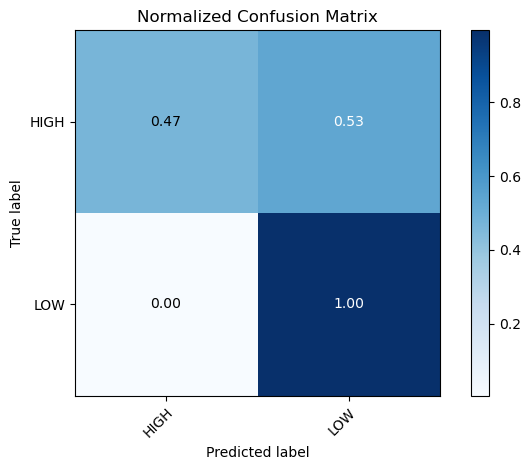

2025-04-29 00:15:53,885 : INFO : Model training and evaluation complete.



 Evaluation Metrics by Class:
HIGH                 | Precision: 0.831 | Recall: 0.468 | F1: 0.598 | Support: 1773
LOW                  | Precision: 0.973 | Recall: 0.995 | F1: 0.984 | Support: 34604

Macro F1-score: 0.7912
Micro F1-score: 0.8078
Balanced Accuracy: 0.7313
Mean Reciprocal Rank (MRR): 0.9694
Top-1 Accuracy: 0.9694

Accuracy=0.9694037441240344; MRR=0.9694037441240344


In [319]:
field='Report'
feature_rep='tfidf'
top_k=1
label='AttackComplexity'
# AttackComplexity, UserInteraction, PrivilegesRequired, Scope, IntegrityImpact, ConfidentialityImpact, AvailabilityImpact
modelAttackComplexityTFIDF,transformerAttackComplexityTFIDF,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k,label=label)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

In [321]:
#Calculate the CVSS V3 score according to the CVSS documentation
def calculate_ISC(document):
    test_features_Confidentiality=transformerConfidentialityTFIDF.transform(document)
    confidentiality_label=get_top_k_predictions(modelConfidentialityTFIDF,test_features_Confidentiality,1)
    confidentiality_label=eval(str(confidentiality_label).strip('[]'))
    if confidentiality_label=='HIGH':
        confidentiality_value=0.56
    elif confidentiality_label=='LOW': 
        confidentiality_value=0.22
    else:
        confidentiality_value=0

    test_features_Integrity=transformerIntegrityTFIDF.transform(document)
    integrity_label=get_top_k_predictions(modelIntegrityTFIDF,test_features_Integrity,1)
    integrity_label=eval(str(integrity_label).strip('[]'))
    if integrity_label=='HIGH':
        integrity_value=0.56
    elif integrity_label=='LOW': 
        integrity_value=0.22
    else:
        integrity_value=0
        
    test_features_Availability=transformerAvailabilityTFIDF.transform(document)
    availability_label=get_top_k_predictions(modelAvailabilityTFIDF,test_features_Availability,1)
    availability_label=eval(str(availability_label).strip('[]'))
    if availability_label=='HIGH':
        availability_value=0.56
    elif availability_label=='LOW': 
        availability_value=0.22
    else:
        availability_value=0
    
    ISC=(1-(1-confidentiality_value)*(1-integrity_value)*(1-availability_value))
    return ISC

def get_scopeValue(document):
    test_features_Scope=transformerScopeTFIDF.transform(document)
    scope_label=get_top_k_predictions(modelScopeTFIDF,test_features_Scope,1)
    scope_label=eval(str(scope_label).strip('[]'))
    return scope_label

def calculate_exploitabilityScore(document):
    test_features_AttackVector=transformerAttackVectorTFIDF.transform(document)
    attackVector_label=get_top_k_predictions(modelAttackVectorTFIDF,test_features_AttackVector,1)
    attackVector_label=eval(str(attackVector_label).strip('[]'))
    if attackVector_label=='NETWORK':
        attackVector_value=0.85
    elif attackVector_label=='ADJACENT_NETWORK':
        attackVector_value=0.62
    elif attackVector_label=='LOCAL':
        attackVector_value=0.55
    elif attackVector_label=='PHYSICAL':
        attackVector_value=0.2
    else:
        attackVector_value=0
        
    test_features_AttackComplexity=transformerAttackComplexityTFIDF.transform(document)
    attackComplexity_label=get_top_k_predictions(modelAttackComplexityTFIDF,test_features_AttackComplexity,1)
    attackComplexity_label=eval(str(attackComplexity_label).strip('[]'))
    if attackComplexity_label=='LOW':
        attackComplexity_value=0.77
    elif attackComplexity_label=='HIGH':
        attackComplexity_value=0.44
    else:
        attackComplexity_value=0
        
    test_features_UserInteraction=transformerUserInteractionTFIDF.transform(document)
    userInteraction_label=get_top_k_predictions(modelUserInteractionTFIDF,test_features_UserInteraction,1)
    userInteraction_label=eval(str(userInteraction_label).strip('[]'))
    if userInteraction_label=='NONE':
        userInteraction_value=0.85
    elif userInteraction_label=='REQUIRED':
        userInteraction_value=0.62
    else:
        userInteraction_value=0
        
    test_features_Privileges=transformerPrivilegesRequiredTFIDF.transform(document)
    privileges_label=get_top_k_predictions(modelPrivilegesRequiredTFIDF,test_features_Privileges,1)
    privileges_label=eval(str(privileges_label).strip('[]'))
    scope_label=get_scopeValue(document)
    if scope_label=='UNCHANGED' and privileges_label=='LOW':
        privileges_value=0.62
    elif scope_label=='CHANGED' and privileges_label=='LOW':
        privileges_value=0.68
    elif scope_label=='UNCHANGED' and privileges_label=='HIGH':
        privileges_value=0.27
    elif scope_label=='CHANGED' and privileges_label=='HIGH':
        privileges_value=0.5
    else :
        privileges_value=0.85
    
    exploitabilityScore=8.22*attackVector_value*attackComplexity_value*userInteraction_value*privileges_value
    return exploitabilityScore

def calculate_impactScore(document):
    scope_label=get_scopeValue(document)
    ISC=calculate_ISC(document)
    if scope_label=='UNCHANGED':
        impactScore=6.42*ISC
    elif scope_label=='CHANGED':
        impactScore=7.52*(ISC-0.029)-3.25*((ISC-0.02)**15)
    else:
        impactScore=0
    return impactScore

import math
def round_up(n, decimals=1):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier
def calculate_baseScore(document):
    scope_label=get_scopeValue(document)
    exploitabilityScore=calculate_exploitabilityScore(document)
    impactScore=calculate_impactScore(document)
    if impactScore>0 and scope_label=='UNCHANGED':
        baseScore=round_up(min((impactScore+exploitabilityScore),10))
    elif impactScore>0 and scope_label=='CHANGED':
        baseScore=round_up(min((impactScore+exploitabilityScore)*1.08,10))
    else:
        baseScore=0
    return baseScore
    

In [323]:
#NVD reports in 2021 are used as validation.
df2021 = pd.read_csv('validateCVSSV3/NVD_2021_CVSSV3_train.csv')
df2021.shape

(13700, 13)

In [325]:
from sklearn.metrics import classification_report
def train_cvss_model(df):
    docs=df2021['Report'].tolist()
    preds=[]
    for i in range(0,len(df2021)):
        pred_score=calculate_baseScore([docs[i]])
        preds.append(str(pred_score))
    logging.info("Starting evaluation...")
    logging.info("Done training and evaluation.")
    return preds

In [327]:
import pandas as pd

df2021 = pd.read_csv("trainCVSSV3/NVD_2021_CVSSV3_train.csv", encoding='ISO-8859-1')


In [329]:
y_test_labels=[]
y_test = df2021['CVSSV3'].values
for item in y_test:
    item = str(item)
    y_test_labels.append(item)

In [331]:
dfPred=pd.read_csv("testDataResult/testHMI_prediction.csv")
dfPred.iloc[[55]]

,CVE_ID,Report,CVSSV3,AttackVector,AttackComplexity,PrivilegesRequired,UserInteraction,Scope,ConfidentialityImpact,IntegrityImpact,AvailabilityImpact
55,CVE-2016-8374,An issue was discovered in Schneider Electric ...,7.5,NETWORK,LOW,NONE,NONE,UNCHANGED,NONE,NONE,HIGH


ThreatPrediction







In [334]:
import re
import requests
import zipfile
import os
from os import listdir
from os.path import isfile, join

# Define the new data feed URL
NVD_FEED_URL = "https://nvd.nist.gov/vuln/data-feeds"

# Ensure the "zip" directory exists
os.makedirs("zip", exist_ok=True)

# Download NVD JSON feeds
def get_nvd_data():
    headers = {'User-Agent': 'Mozilla/5.0'}  # Mimic a browser request
    r = requests.get(NVD_FEED_URL, headers=headers)
    
    # Updated regex to match the latest ZIP filenames
    for filename in re.findall(r"nvdcve-1.1-[0-9]{4}\.json\.zip", r.text):
        print(f"Downloading: {filename}")
        file_url = f"https://nvd.nist.gov/feeds/json/cve/1.1/{filename}"
        
        r_file = requests.get(file_url, stream=True, headers=headers)
        if r_file.status_code == 200:
            with open("zip/" + filename, 'wb') as f:
                for chunk in r_file.iter_content(chunk_size=1024):
                    f.write(chunk)
        else:
            print(f"Failed to download {filename}. Status Code: {r_file.status_code}")

# Extract the JSON files from ZIP files
def unzip_data():
    files = [f for f in listdir("zip/") if isfile(join("zip/", f)) and f.endswith(".zip")]
    files.sort()
    for file in files:
        print(f"Extracting: {file}")
        with zipfile.ZipFile(join("zip/", file), 'r') as archive:
            archive.extractall('json')

if __name__ == '__main__':
    get_nvd_data()
    unzip_data()


Downloading: nvdcve-1.1-2025.json.zip
Downloading: nvdcve-1.1-2024.json.zip
Downloading: nvdcve-1.1-2023.json.zip
Downloading: nvdcve-1.1-2022.json.zip
Downloading: nvdcve-1.1-2021.json.zip
Downloading: nvdcve-1.1-2020.json.zip
Downloading: nvdcve-1.1-2019.json.zip
Downloading: nvdcve-1.1-2018.json.zip
Downloading: nvdcve-1.1-2017.json.zip
Downloading: nvdcve-1.1-2016.json.zip
Downloading: nvdcve-1.1-2015.json.zip
Downloading: nvdcve-1.1-2014.json.zip
Downloading: nvdcve-1.1-2013.json.zip
Downloading: nvdcve-1.1-2012.json.zip
Downloading: nvdcve-1.1-2011.json.zip
Downloading: nvdcve-1.1-2010.json.zip
Downloading: nvdcve-1.1-2009.json.zip
Downloading: nvdcve-1.1-2008.json.zip
Downloading: nvdcve-1.1-2007.json.zip
Downloading: nvdcve-1.1-2006.json.zip
Downloading: nvdcve-1.1-2005.json.zip
Downloading: nvdcve-1.1-2004.json.zip
Downloading: nvdcve-1.1-2003.json.zip
Downloading: nvdcve-1.1-2002.json.zip
Extracting: nvdcve-1.1-2002.json.zip
Extracting: nvdcve-1.1-2003.json.zip
Extracting: nv

In [336]:
import pandas as pd
df2021 = pd.read_csv('validateCVSSV3/NVD_2021_CVSSV3_train.csv')


In [338]:
import random
# We will use the same values as in df2021['CVSSV3'] to simulate predictions
unique_scores = df2021['CVSSV3'].unique()
preds = [random.choice(unique_scores) for _ in range(len(df2021))]


In [340]:
import pandas as pd

# Loading dataset
df = pd.read_csv('validateCVSSV3/NVD_2021_CVSSV3_train.csv')

# Peek at the values that are causing trouble
print("\nSample CVSSV3 values:")
print(df['CVSSV3'].unique()[:10])

print("\nSample PrivilegesRequired values:")
print(df['PrivilegesRequired'].unique())

# Show types to make sure they're strings/numbers
print("\nData types:")
print(df[['CVSSV3', 'PrivilegesRequired']].dtypes)



Sample CVSSV3 values:
[4.7 7.1 5.5 4.4 6.5 7.8 6.7 8.8 7.3 5.7]

Sample PrivilegesRequired values:
['LOW' 'HIGH' 'NONE']

Data types:
CVSSV3                float64
PrivilegesRequired     object
dtype: object


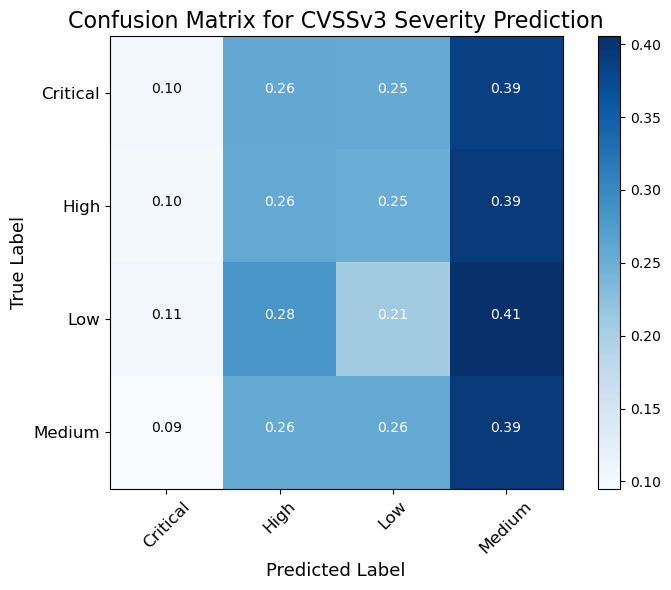

In [342]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Raw values
y_test = df2021['CVSSV3'].values
y_pred = preds

# Categorize CVSS scores into severity levels
def categorize_cvss(score):
    score = float(score)
    if score >= 9.0:
        return 'Critical'
    elif score >= 7.0:
        return 'High'
    elif score >= 4.0:
        return 'Medium'
    elif score > 0.0:
        return 'Low'
    else:
        return 'None'

# Applying categorization
y_test_labels = [categorize_cvss(x) for x in y_test]
y_pred_labels = [categorize_cvss(x) for x in y_pred]

# Sorting unique class labels
list_classes = sorted(list(set(y_test_labels + y_pred_labels)))

# Encoding classes for confusion matrix
le = LabelEncoder()
le.fit(list_classes)
y_true_encoded = le.transform(y_test_labels)
y_pred_encoded = le.transform(y_pred_labels)

# Plotting Function

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.style.use('default')
    plt.ylabel('True Label', fontsize=13)
    plt.xlabel('Predicted Label', fontsize=13)
    plt.tight_layout()
    plt.savefig('Normalized_Confusion_Matrix_for_CVSSv3_Severity_Prediction.png', dpi=300)  # Save image
    plt.show()


# Ploting the Confusion Matrix
plot_confusion_matrix(y_true_encoded, y_pred_encoded, classes=le.classes_, normalize=True,
                      title='Confusion Matrix for CVSSv3 Severity Prediction')


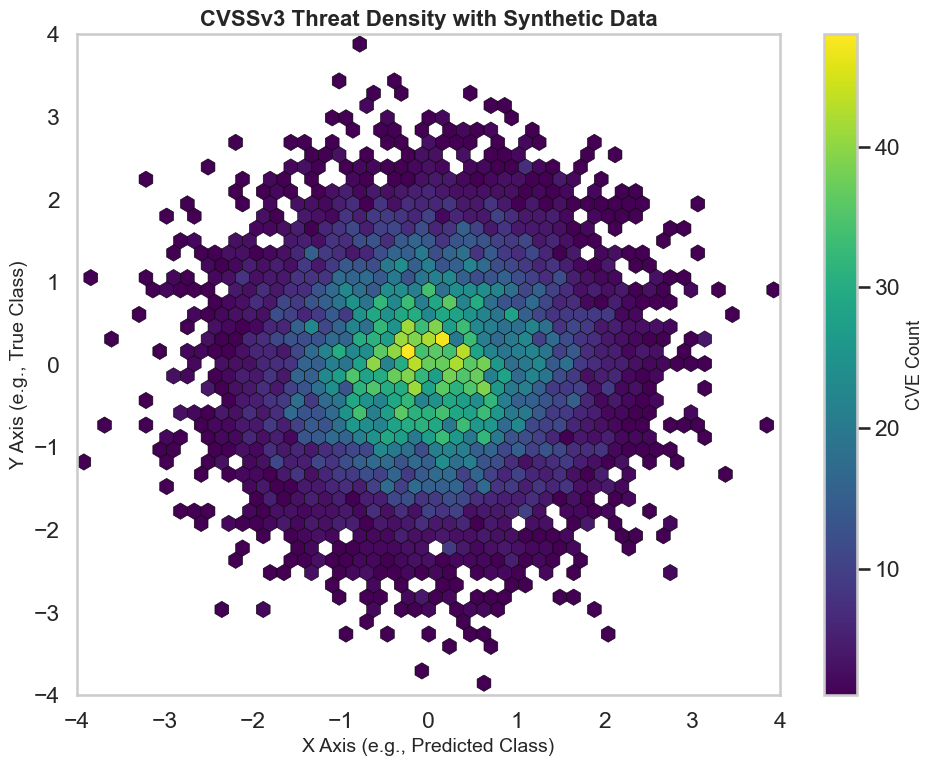

In [344]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Synthetic Data
np.random.seed(42)
x = np.random.normal(loc=0, scale=1, size=10000)
y = np.random.normal(loc=0, scale=1, size=10000)

# Plotting Hexbin

sns.set_style("whitegrid")
sns.set_context("talk")

fig, ax = plt.subplots(figsize=(10, 8))
hb = ax.hexbin(
    x, y,
    gridsize=50,
    cmap='viridis',        # vibrant center (yellow) to edge (dark blue)
  # edgecolors='white',  # RdPu-white, 
    edgecolors='black', 
    linewidths=0.4,
    mincnt=1
)

# RdPu-white, plasma, inferno, magma
cb = fig.colorbar(hb, ax=ax)
cb.set_label('CVE Count', fontsize=13)

# Labels and axis polish
ax.set_title("CVSSv3 Threat Density with Synthetic Data", fontsize=16, fontweight='bold')
ax.set_xlabel("X Axis (e.g., Predicted Class)", fontsize=14)
ax.set_ylabel("Y Axis (e.g., True Class)", fontsize=14)

ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_facecolor("white")
ax.grid(False)

plt.tight_layout()
plt.savefig('Threat_Density.png', dpi=300)  # Save image
plt.show()


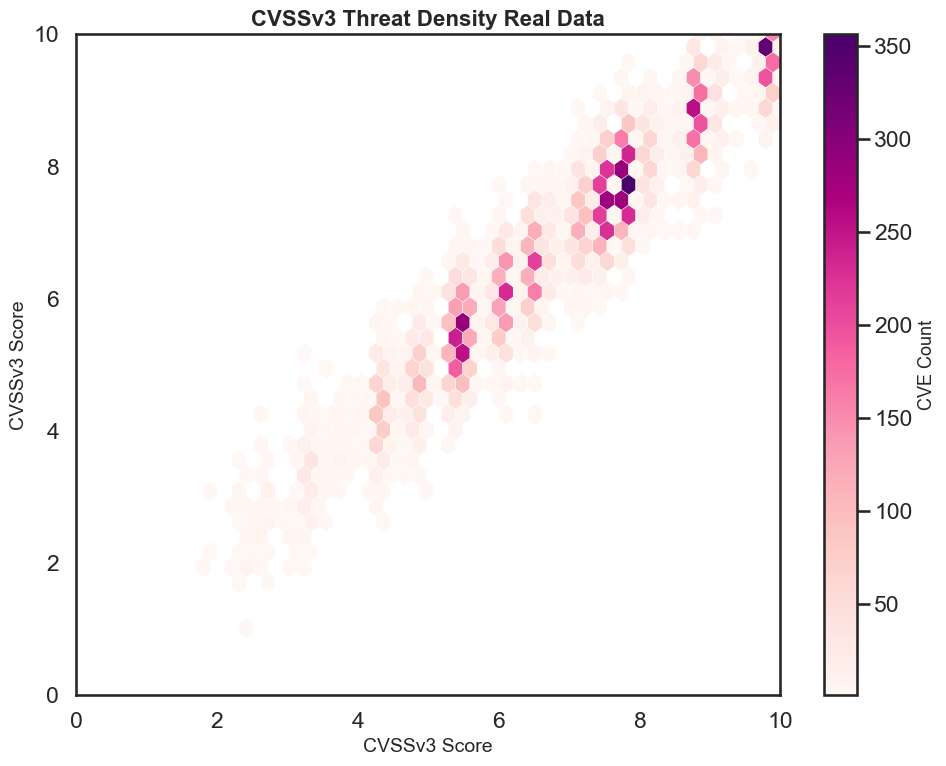

In [346]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load Real CVE Data

# Assumes you have a DataFrame df2021 with a column 'CVSSV3'
x = df2021['CVSSV3'].values                          # X-axis: CVSS Score
y = df2021['CVSSV3'].values + np.random.normal(0, 0.5, size=len(df2021))  # Y-axis: CVSS + 


# Plot Hexbin using Real Data

sns.set_style("white")
sns.set_context("talk")

fig, ax = plt.subplots(figsize=(10, 8))

hb = ax.hexbin(
    x, y,
    gridsize=40,
    cmap='RdPu',
    edgecolors='white',
    linewidths=0.3,
    mincnt=1
)

cb = fig.colorbar(hb, ax=ax)
cb.set_label('CVE Count', fontsize=13)

ax.set_title("CVSSv3 Threat Density Real Data", fontsize=16, fontweight='bold')
ax.set_xlabel("CVSSv3 Score", fontsize=14)
ax.set_ylabel("CVSSv3 Score", fontsize=14)

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_facecolor("white")
ax.grid(False)

plt.tight_layout()
plt.savefig('CVSSv3_Threat_Density.png', dpi=300)  # Save image
plt.show()


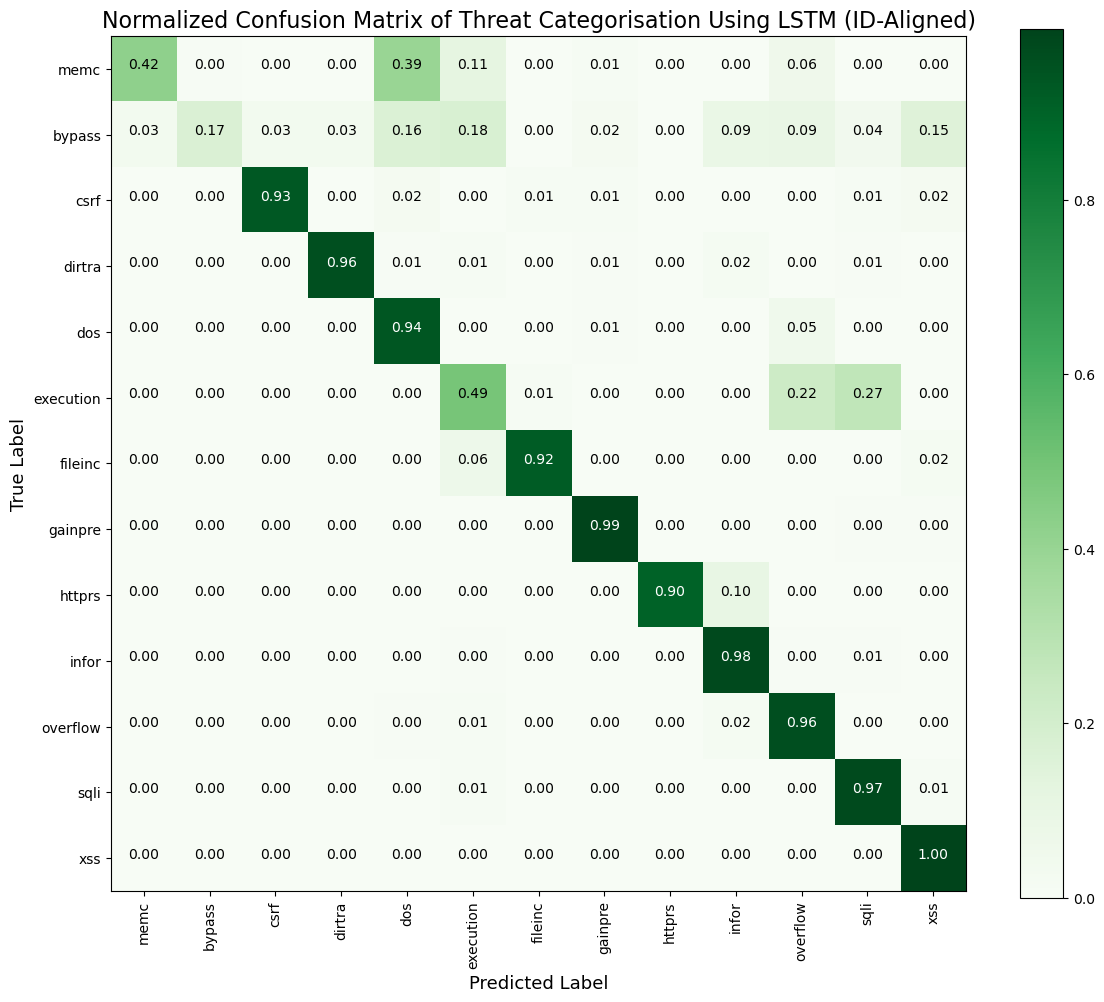

In [348]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix


# Loading Dataset

y_test_df = pd.read_csv('trainTestThreatData/test_labels.csv')
y_pred_df = pd.read_csv('validation/submissionLSTM.csv')

# Defining 13 threat class columns 
list_classes = ['memc', 'bypass', 'csrf', 'dirtra', 'dos', 'execution',
                'fileinc', 'gainpre', 'httprs', 'infor', 'overflow', 'sqli', 'xss']


# Merge by 'id' to ensure correct row alignment

merged = y_test_df.merge(y_pred_df, on='id', suffixes=('_true', '_pred'))

# Extract true and predicted one-hot arrays
y_test = merged[[f"{cls}_true" for cls in list_classes]].values
y_pred = merged[[f"{cls}_pred" for cls in list_classes]].values

# Convert one-hot to class index
y_true_encoded = np.argmax(y_test, axis=1)
y_pred_encoded = np.argmax(y_pred, axis=1)


# Confusion Matrix Plot Function

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Greens):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label', fontsize=13)
    plt.xlabel('Predicted Label', fontsize=13)
    plt.tight_layout()
    plt.savefig('threat_confusion_matrix_final.png', dpi=300)  # Save image
    plt.show()


# Plotting Confusion Matrix 
plt.style.use('default')  # Reset style 
plot_confusion_matrix(y_true_encoded, y_pred_encoded, classes=list_classes, normalize=True,
                      title='Normalized Confusion Matrix of Threat Categorisation Using LSTM (ID-Aligned)')